In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import emcee
from multiprocessing import Pool
import time 
import matplotlib.pyplot as plt
import corner

matplotlib.rcParams.update({'font.size': 18})
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data', 'df_raw_data_2', 'df_travel_history', 'df_resources'])

In [5]:
df_district = get_district_time_series(dataframes)

In [6]:
## TODO: Make splits
df_train = df_district

## Loss Calculation Functions

In [7]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Initialize params and state values

In [8]:
vanilla_params, testing_params, state_init_values = init_params()

In [9]:
vanilla_params

{'R0': 2.2,
 'T_trans': 1.3181818181818181,
 'T_inc': 5.2,
 'T_inf': 2.9,
 'T_recov_mild': 11.1,
 'T_recov_severe': 28.6,
 'T_hosp': 5,
 'T_death': 32,
 'P_mild': 0.78,
 'P_severe': 0.2,
 'P_fatal': 0.02,
 'intervention_day': 100,
 'lockdown_removal_day': 45,
 'intervention_amount': 0.33,
 'N': 7000000.0}

In [10]:
vanilla_params

{'R0': 2.2,
 'T_trans': 1.3181818181818181,
 'T_inc': 5.2,
 'T_inf': 2.9,
 'T_recov_mild': 11.1,
 'T_recov_severe': 28.6,
 'T_hosp': 5,
 'T_death': 32,
 'P_mild': 0.78,
 'P_severe': 0.2,
 'P_fatal': 0.02,
 'intervention_day': 100,
 'lockdown_removal_day': 45,
 'intervention_amount': 0.33,
 'N': 7000000.0}

In [11]:
state_init_values

OrderedDict([('S', 0.9999998571428571),
             ('E', 0),
             ('I', 1.4285714285714285e-07),
             ('D_E', 0),
             ('D_I', 0),
             ('R_mild', 0),
             ('R_severe_home', 0),
             ('R_severe_hosp', 0),
             ('R_fatal', 0),
             ('C', 0),
             ('D', 0)])

## Set priors for parameters of interest

In [53]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1, 3)#(1.6, 3)
prior_ranges['T_inc'] = (1, 5) #(4, 5)
prior_ranges['T_inf'] = (1, 4) #(3, 4)
prior_ranges['T_recov_severe'] = (9, 20)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['intervention_amount'] = (0.3, 1)
prior_ranges['c_sigma'] = (0.001, 5)

def param_init():
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [54]:
proposal_sigmas = OrderedDict()
for key in prior_ranges:
    proposal_sigmas[key] = 1#0.025 * (prior_ranges[key][1] - prior_ranges[key][0])

def proposal(theta_old):
    theta_new = np.random.normal(loc=[*theta_old.values()], scale=[*proposal_sigmas.values()])
    return dict(zip(theta_old.keys(), theta_new))


## Log Likelihood and Prior

In [55]:
type(OrderedDict())

collections.OrderedDict

In [56]:
import collections
def log_likelihood(theta):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    #alpha = 0.01
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])
    true = np.array(df_train['total_infected'])
    #sigma = alpha * true.std()
    sigma = theta['c_sigma']
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
#     prior = 1
#     for key in prior_ranges:
#         if in_valid_range(key, theta[key]):
#             prior *= 1 / (prior_ranges[key][1] - prior_ranges[key][0])
#         else:
#             prior = 0
#             break
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [27]:
T = 1
key_list = ['R0','T_inc','T_inf','T_recov_severe','P_severe','intervention_amount', 'c_sigma']

def convert_to_dict(theta):
    if type(theta) != dict:
        theta_vals = theta.copy()
        theta = dict()
        for key_index in range(len(key_list)):
            theta[key_list[key_index]] = theta_vals[key_index]
    return theta

def log_probability(theta):
    theta = convert_to_dict(theta)
    return log_likelihood(theta) + log_prior(theta)

def accept(theta_old, theta_new, boltzmann = False):  
    x_new = log_probability(theta_new)
    x_old = log_probability(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))
    
def anneal_accept(iter):
    prob = 1 - np.exp(-(1/(iter + 1e-10)))
    x = np.random.uniform(0, 1)
    return (x < prob)

In [19]:
optimum_params = { 'R0': 2.1039262514239443, 'T_inc': 4.29031222687138,
                  'T_inf': 3.0377562096514046, 'T_recov_severe': 9.594716552601186,
                  'P_severe': 0.961325014139492, 'intervention_amount': 0.4101211254804955,
                    'c_sigma' : 1} # Sigma unknown, need to fit to likelihood

In [20]:
optimum_params.values()

dict_values([2.1039262514239443, 4.29031222687138, 3.0377562096514046, 9.594716552601186, 0.961325014139492, 0.4101211254804955, 1])

## Metropolis loop

In [21]:
def metropolis(iter=1000):
    theta = param_init()
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta)
        if anneal_accept(i):
            theta = theta_new
        else:
            if accept(theta, theta_new):
                theta = theta_new
            else:
                rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

proposal_function – The proposal function. It should take 2 arguments: a numpy-compatible random number generator and a (K, ndim) list of coordinate vectors. This function should return the proposed position and the log-ratio of the proposal probabilities (ln𝑞(𝑥;𝑥′)−ln𝑞(𝑥′;𝑥) where 𝑥′ is the proposed coordinate).

In [22]:

def proposal_emcee(rng, theta_list):
    theta = theta_list[-1]
    theta_new = proposal(theta)
    if anneal_accept(i):
        theta = theta_new
    return theta, 0

In [ ]:
init_param = []
for key in prior_ranges:
    init_param.append(optimum_params[key])

## Set up Emcee

In [50]:
nwalkers = 30
nsteps = 20000
ndim = len(init_param)
pos = init_param + 1e-2 * np.random.randn(nwalkers, ndim)
filename = "emcee.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                #moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2),],
                                backend = backend,
                                   a=0.2)

In [25]:
"""start = time.time()
sampler.run_mcmc(pos, nsteps, progress=True);
end = time.time()
serial_time = end - start

   
    start = time.time()
    sampler.run_mcmc(pos, nsteps, progress=True);
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))"""

'start = time.time()\nsampler.run_mcmc(pos, nsteps, progress=True);\nend = time.time()\nserial_time = end - start\n\n   \n    start = time.time()\n    sampler.run_mcmc(pos, nsteps, progress=True);\n    end = time.time()\n    multi_time = end - start\n    print("Multiprocessing took {0:.1f} seconds".format(multi_time))\n    print("{0:.1f} times faster than serial".format(serial_time / multi_time))'

In [51]:
# Run EMcee sampler
sampler.run_mcmc(pos, nsteps, progress=True);

  0%|          | 94/20000 [00:28<1:17:22,  4.29it/s]Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-27-3c2f45fc3d3d>", line 14, in log_probability
    return log_likelihood(theta) + log_prior(theta)
  File "<ipython-input-15-c44fe7ddb387>", line 14, in log_likelihood
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
ValueError: operands could not be broadcast together with shapes (48,) (27,) 
  0%|          | 94/20000 [00:46<2:45:38,  2.00it/s]

emcee: Exception while calling your likelihood function:
  params: [3.14871811e-02 2.60660108e+01 3.17968229e+01 5.96667284e+01
 4.02286358e+01 6.47083391e+00 4.11650815e+01]
  args: []
  kwargs: {}
  exception:


ValueError: operands could not be broadcast together with shapes (48,) (27,) 

In [ ]:
#acc, rej = metropolis(iter=20000)

In [ ]:
#df_samples = pd.DataFrame(acc)

In [30]:
samples = sampler.get_chain()
#samples[:,sampler.acceptance_fraction > 0.1,:].shape

In [31]:
sampler.acceptance_fraction

array([0.1961223 , 0.12602535, 0.1043997 , 0.15883669, 0.20283371,
       0.07680835, 0.17449664, 0.20134228, 0.1349739 , 0.17076808,
       0.15436242, 0.15734526, 0.1841909 , 0.14466816, 0.17449664])

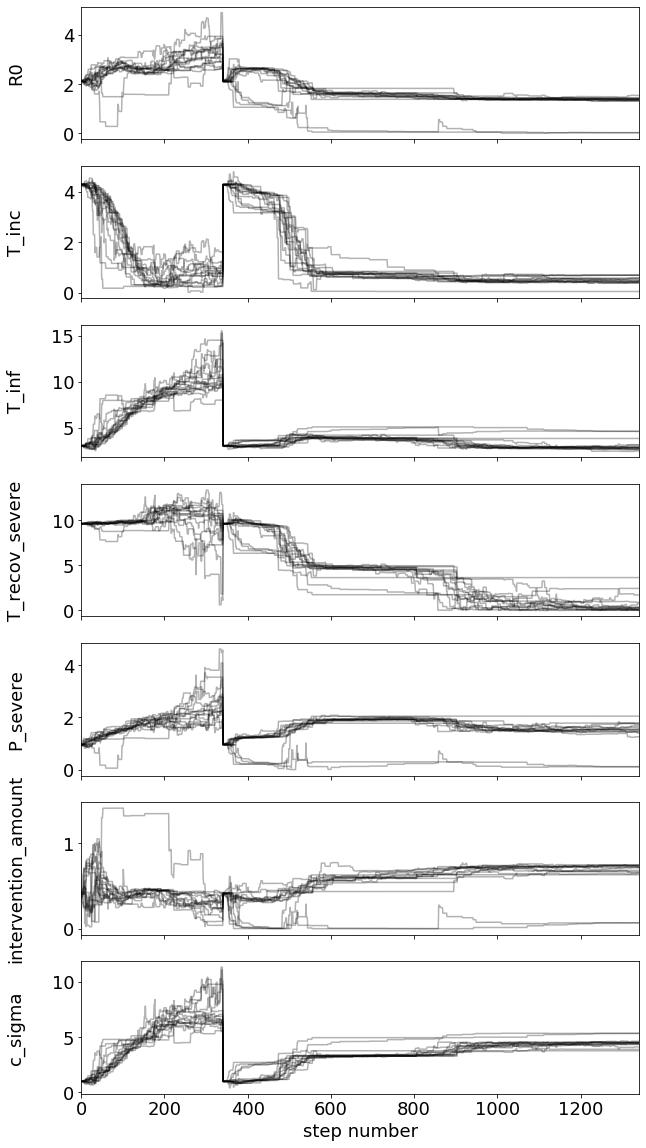

In [32]:
# View Time series of parameter values for multiple chains

fig, axes = plt.subplots(ndim, figsize=(10, 20), sharex=True)
samples = sampler.get_chain()
#samples = samples[:,sampler.acceptance_fraction > 0.1,:]
labels = key_list
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [33]:
#Get autocorrelation time of the chain
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 27;
tau: [168.54373635 133.08352085 141.47887765 184.43571798  74.56594586
 164.10229455  46.61592506]

In [34]:
flat_samples = sampler.get_chain(discard=200, thin=20, flat=True)#[:,sampler.acceptance_fraction > 0.1,:]
#num_samples, num_chains, num_params = flat_samples.shape
#flat_samples = flat_samples.reshape((num_samples*num_chains, num_params))


In [35]:
flat_samples[:,0].shape

(855,)

## Results

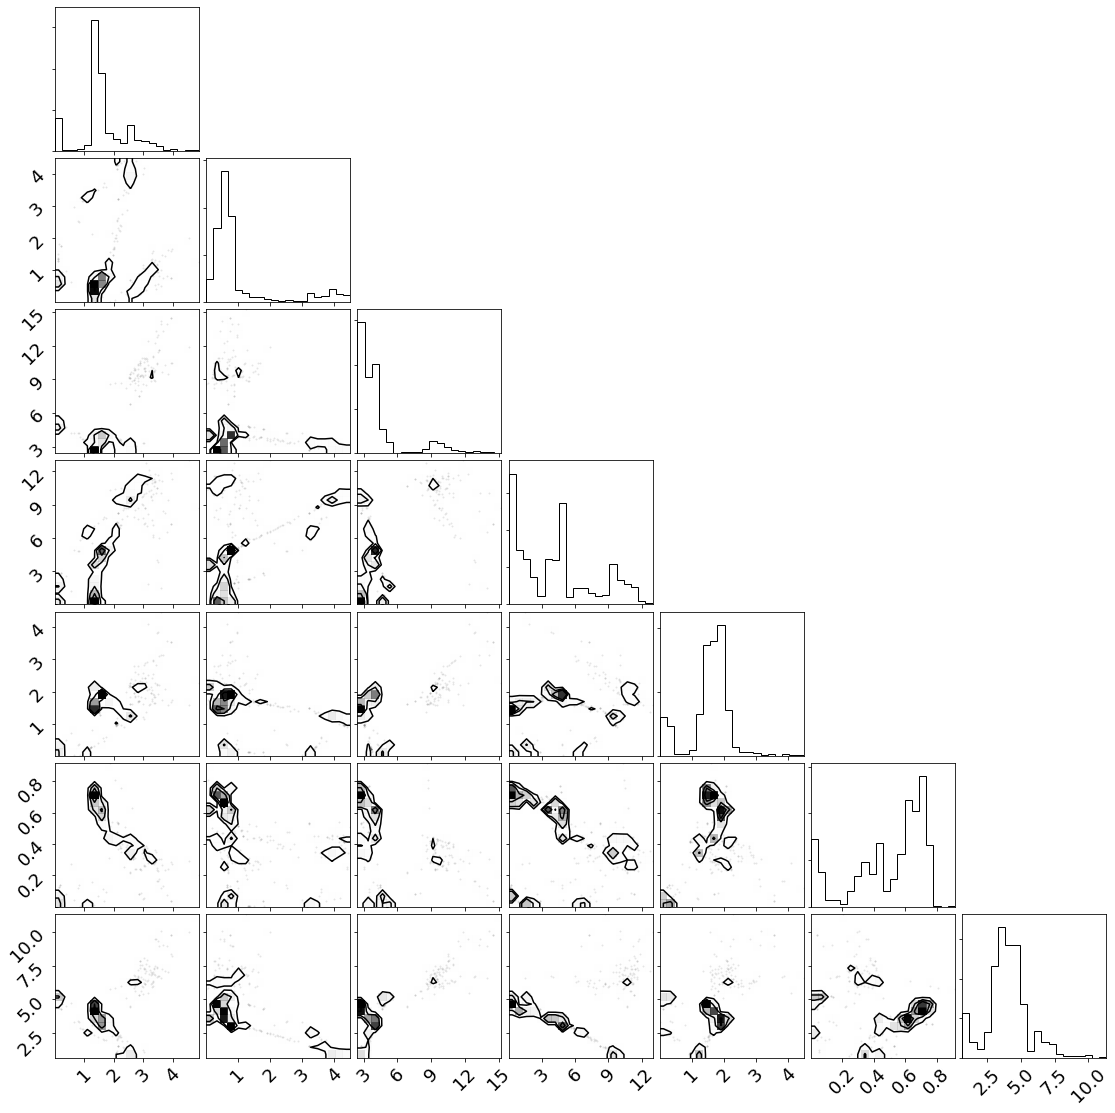

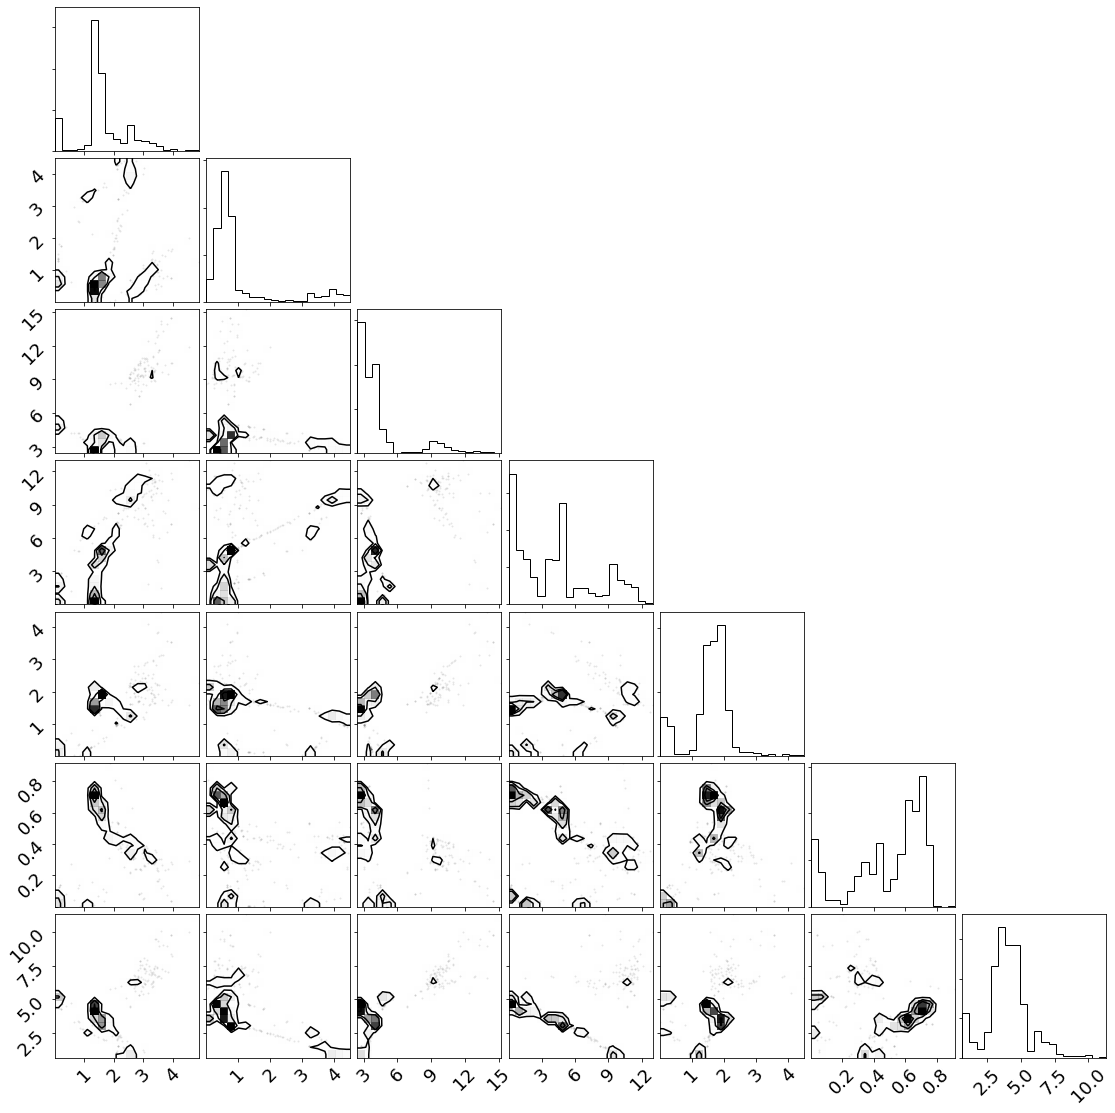

In [36]:
# View corner plot to check pairwise correlations
corner.corner(flat_samples)

(array([ 80.,   1.,   2.,   5.,  15., 318., 189.,  43.,  29.,  19.,  64.,
         26.,  23.,  20.,  12.,   3.,   4.,   0.,   1.,   1.]),
 array([6.22919354e-04, 2.45292209e-01, 4.89961499e-01, 7.34630789e-01,
        9.79300079e-01, 1.22396937e+00, 1.46863866e+00, 1.71330795e+00,
        1.95797724e+00, 2.20264653e+00, 2.44731582e+00, 2.69198511e+00,
        2.93665440e+00, 3.18132369e+00, 3.42599298e+00, 3.67066227e+00,
        3.91533156e+00, 4.16000085e+00, 4.40467014e+00, 4.64933943e+00,
        4.89400872e+00]),
 <a list of 20 Patch objects>)

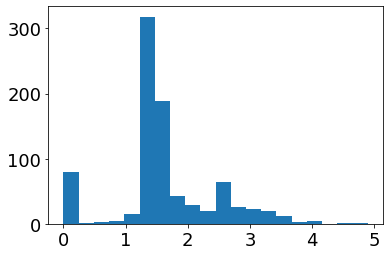

In [37]:
plt.hist(flat_samples[:,0], bins=20)

## Use samples to estimate confidence intervals

In [38]:
pred_dfs = list()
optimiser = Optimiser()
default_params = optimiser.init_default_params(df_train)

In [39]:
sample_indices = np.random.randint(len(flat_samples), size=1000)
posterior_samples = flat_samples
for i in tqdm(sample_indices):
    pred_dfs.append(optimiser.solve( convert_to_dict(posterior_samples[int(i)]), default_params, df_train))

100%|██████████| 1000/1000 [00:16<00:00, 59.68it/s]


In [40]:
for df in pred_dfs:
    df.set_index('date', inplace=True)

In [41]:
result = pred_dfs[0].copy()
for col in result.columns:
    result["{}_low".format(col)] = ''
    result["{}_high".format(col)] = ''

In [42]:
def get_PI(date, key, multiplier=1.96):
    scaling_factor = 1
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
    mu = np.array(pred_samples).mean()
    sigma =  scaling_factor*np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

In [43]:
 pred_dfs[0]

,S,E,I,D_E,D_I,R_mild,R_severe_home,R_severe_hosp,R_fatal,C,D,hospitalisations,recoveries,fatalities,infectious_unknown,total_infected
date,,,,,,,,,,,,,,,,
2020-03-09,9999999,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2020-03-10,9999998,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2020-03-11,9999998,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2020-03-12,9999998,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2020-03-13,9999997,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1
2020-03-14,9999997,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1
2020-03-15,9999996,0,2,0,0,-1,0,2,0,0,0,2,0,0,2,2
2020-03-16,9999995,0,2,0,0,-1,0,2,0,0,0,2,0,0,2,2
2020-03-17,9999994,0,3,0,0,0,0,3,0,0,0,3,0,0,3,3


In [44]:
for date in tqdm(pred_dfs[0].index):
    for key in pred_dfs[0]:
        result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(date, key)

100%|██████████| 48/48 [00:08<00:00,  5.69it/s]


In [45]:
result

,S,E,I,D_E,D_I,R_mild,R_severe_home,R_severe_hosp,R_fatal,C,...,hospitalisations_low,hospitalisations_high,recoveries_low,recoveries_high,fatalities_low,fatalities_high,infectious_unknown_low,infectious_unknown_high,total_infected_low,total_infected_high
date,,,,,,,,,,,,,,,,,,,,,
2020-03-09,9999999.000,0.000,1.000,0.0,0.0,0.000,0.0,0.000,0.0,0.000,...,0,0,0,0,0,0,1,1,0,0
2020-03-10,9999998.000,0.000,0.168,0.0,0.0,0.000,0.0,0.000,0.0,0.000,...,0,0,0,0,0,0,-0.564778,0.900778,0,0
2020-03-11,9999997.912,0.059,0.708,0.0,0.0,0.000,0.0,0.253,0.0,0.000,...,-0.599073,1.10507,0,0,0,0,-0.183177,1.59918,-0.599073,1.10507
2020-03-12,9999997.127,0.074,0.777,0.0,0.0,0.000,0.0,0.660,0.0,0.000,...,-0.272598,1.5926,0,0,0,0,-0.0388663,1.59287,-0.272598,1.5926
2020-03-13,9999996.782,0.084,0.795,0.0,0.0,0.000,0.0,1.263,0.0,0.000,...,-0.282583,2.80858,0,0,0,0,0.00374482,1.58626,-0.282583,2.80858
2020-03-14,9999996.217,0.146,0.940,0.0,0.0,-0.191,0.0,1.563,0.0,0.000,...,-0.0532942,3.17929,0,0,0,0,-0.0008,1.8808,-0.0532942,3.17929
2020-03-15,9999995.605,0.181,0.996,0.0,0.0,-0.375,0.0,2.188,0.0,0.000,...,0.0066195,4.36938,0,0,0,0,-0.0373941,2.02939,0.0066195,4.36938
2020-03-16,9999994.809,0.227,1.052,0.0,0.0,-0.201,0.0,2.834,0.0,0.000,...,0.0232999,5.6447,0,0,0,0,-0.106385,2.21038,0.0232999,5.6447
2020-03-17,9999993.964,0.290,1.589,0.0,0.0,-0.176,0.0,3.554,0.0,0.000,...,0.142764,6.96524,0,0,0,0,-0.119777,3.29778,0.142764,6.96524


## Visualize the intervals

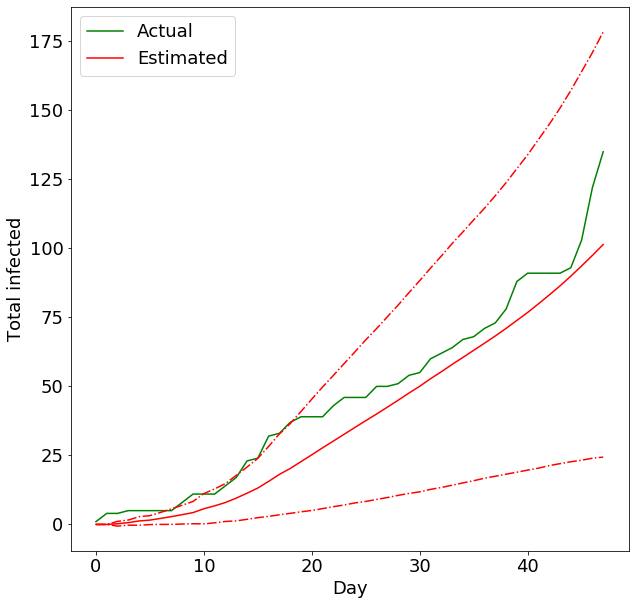

In [46]:
plt.figure(figsize=(10, 10))
plt.plot(df_train['total_infected'], c='g', label='Actual')
plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
plt.xlabel("Day")
plt.ylabel("Total infected")
plt.legend()